In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from pyDOE import lhs
from collections import OrderedDict
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.9.0


In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        n_hidden = len(layers) 
        self.activation = nn.Tanh
        layer_list = []

        for i in range(n_hidden-2):

            linear = torch.nn.Linear(layers[i], layers[i+1])

            nn.init.xavier_normal_(linear.weight.data, gain=1.0)
            nn.init.zeros_(linear.bias.data)

            layer_list.append(
                ('layer_%d' % i, linear)
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )
        
        linear = torch.nn.Linear(layers[n_hidden-2], layers[n_hidden-1])
        nn.init.xavier_normal_(linear.weight.data, gain=1.0)
        nn.init.zeros_(linear.bias.data)

        layer_list.append(('layer_%d' % (n_hidden-2), linear))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class PINN_Burgers:
    
    def __init__(self, net, Xt_u, Y, Xt_f, lb, ub, device):
        
        # data
        self.X_u = Xt_u[:,0:1]; self.t_u = Xt_u[:,1:2]
        self.X_f = Xt_f[:,0:1]; self.t_f = Xt_f[:,1:2]

        self.Y = torch.tensor(Y).float().to(device)
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # net
        self.net = net.to(device)

        # opt: using both Adam and LBFGS
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.iter = 0
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=0.003)

    def net_U(self, x, t):
        xt = torch.cat((x,t), dim=1)
        xt = 2*(xt-self.lb)/(self.ub-self.lb) - 1
        u = self.net(xt)
        return u

    def net_F(self, x, t):
        lambda_1 = 1        
        lambda_2 = 0.01/np.pi

        u = self.net_U(x, t)

        u_t = torch.autograd.grad(u, t, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), 
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
      
        F = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return F

    def _train_step(self):
        
        X_u = torch.tensor(self.X_u, requires_grad=True).float().to(device)
        t_u = torch.tensor(self.t_u, requires_grad=True).float().to(device)
        X_f = torch.tensor(self.X_f, requires_grad=True).float().to(device)
        t_f = torch.tensor(self.t_f, requires_grad=True).float().to(device)
        
        u_pred = self.net_U(X_u, t_u)
        f_pred = self.net_F(X_f, t_f)
        loss = torch.mean((self.Y-u_pred)**2) + torch.mean(f_pred**2)

        return loss

    def _closure(self):
        loss = self._train_step()
        self.opt_LBFGS.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 200 == 0:
            print('epoch: {}  loss: {:.3e}'.format(self.iter, 
                                                    loss.item()))
        return loss

    def train(self, epochs):
        self.net.train() # training mode
        for epoch in range(epochs):
            
            loss = self._train_step() 
            
            self.opt_Adam.zero_grad()
            loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 200 == 0:
                print('epoch: {}  loss: {:.3e}'.format(epoch+1, 
                                                        loss.item()))
        self.opt_LBFGS.step(self._closure)

    def predict(self, x):
        
        x = torch.tensor(x, requires_grad=True).float().to(device)
    
        self.net.eval()
       
        u_pred = self.net_U(x[:,0:1], x[:,1:2])
        
        return u_pred.detach().cpu().numpy()
        




In [4]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

import scipy.io
data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

# boundary
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

# collocation
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

# training data
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [5]:
net = DNN(layers)
net

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=20, bias=True)
    (activation_6): Tanh()
    (layer_7): Linear(in_features=20, out_features=20, bias=True)
    (activation_7): Tanh()
    (layer_8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [6]:
pinn = PINN_Burgers(net, X_u_train, u_train, X_f_train, lb, ub, device)
pinn.train(0)

epoch: 200  loss: 2.250e-02
epoch: 400  loss: 1.810e-03
epoch: 600  loss: 4.963e-04
epoch: 800  loss: 2.798e-04
epoch: 1000  loss: 1.552e-04
epoch: 1200  loss: 8.460e-05
epoch: 1400  loss: 4.929e-05
epoch: 1600  loss: 3.519e-05
epoch: 1800  loss: 2.631e-05
epoch: 2000  loss: 2.039e-05
epoch: 2200  loss: 1.709e-05
epoch: 2400  loss: 1.322e-05
epoch: 2600  loss: 1.105e-05
epoch: 2800  loss: 8.998e-06
epoch: 3000  loss: 7.931e-06
epoch: 3200  loss: 6.905e-06
epoch: 3400  loss: 5.954e-06
epoch: 3600  loss: 5.033e-06
epoch: 3800  loss: 4.432e-06
epoch: 4000  loss: 3.947e-06
epoch: 4200  loss: 3.561e-06
epoch: 4400  loss: 3.183e-06
epoch: 4600  loss: 2.765e-06
epoch: 4800  loss: 2.517e-06


In [7]:
u_pred = pinn.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

Error u: 1.036116e-03


Text(0.5, 1.0, '$t = 0.75$')

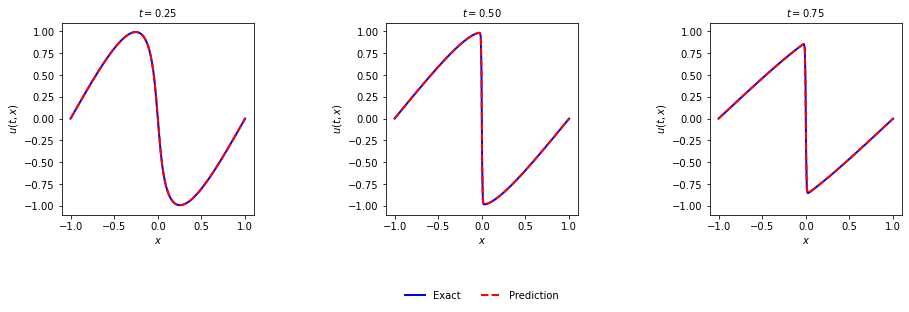

In [10]:
# testing data at t = 0.25, 0.5, 0.75
X_u_test_25 = np.hstack([x, 0.25*np.ones_like((x))]); u_test_25 = Exact[25]
X_u_test_50 = np.hstack([x, 0.50*np.ones_like((x))]); u_test_50 = Exact[50]
X_u_test_75 = np.hstack([x, 0.75*np.ones_like((x))]); u_test_75 = Exact[75]

u_pred_25 = pinn.predict(X_u_test_25)
u_pred_50 = pinn.predict(X_u_test_50)
u_pred_75 = pinn.predict(X_u_test_75)

fig = plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_25, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_50, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_75, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)